# Segmentation: Clustering (mean-shift) + Graph-based methods (graph-cut, random walk, etc)

# Clustering: K-means-Clustering and Mean-Shift Methods
Siru Chen

Clustering:
  * Grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar to each other than to those in other groups.

Feature Space:
* the multi-dimensional space where each dimension corresponds to a feature of the data being analyzed.

Feature Space and Clustering:
* Clustering algorithms require a way to quantitatively compare different data items.
* The feature space provides this by representing each item as a vector of features, allows clustering algorithms to compute similarity among datas.

## Clustering Methods
**Parametric Clustering Methods**:Assume a model about the data distribution and fit parameters to this model.
* Often require a priori knowledge of the number of clusters present (K-mean clustering)
* Or assume the same shape for all clusters in the space (Gaussian Mixture Model)


Arbitrarily structured feature spaces can be analyzed only by nonparametric methods since these methods do not have embedded assumptions.

**Non-parametric Clustring Methods**: Do not make assumptions about the form of cluster model, and try to infer the structure directly from data.
   * Hierarchical method: aggregate or divide the data based on proximity measure.
   * Density Estimation: Consider feature space as the empirical p.d.f. of the represented parameters.

## K-mean Clustring
$$J = \sum_{i=1}^{k} \sum_{x \in S_i} \|x - \mu_i\|^2$$
* Clusters $S_i$: a cluster that contain a subset of the entire dataset. $x \in S_i$ indicates the sum is taken over all data point x that have been assigned to cluster i.
* Centroids $\mu_i$: the mean of the points in the cluster $S_i$. It is calculated as the average of all points assigned to that cluster.

Goal: To find the set of $\mu_i$ and $S_i$ so the total Euclidean distance between each point data x and its cluster center $\mu_i$ is minimized.

### K mean Step by Step
$$J = \sum_{i=1}^{k} \sum_{x \in S_i} \|x - \mu_i\|^2$$
* Step one: selecting k initial centroids
* Assignment: assign each data point to nearest centroids.
    * Give each datapoint label $S_i$
    * Form k cluster, each cluster corresponds to a group of data points.
* Update: recalculate centroids: $\mu_i=\frac{1}{|S_i|}\sum_{x \in S_i}x$
    * As centroids are relocated to the actual center of their respective clusters, thus reduce $J$.
* Convergence Check: repeat until the centroids no longer change significantly, or change in J between iternation falls below a threshold.

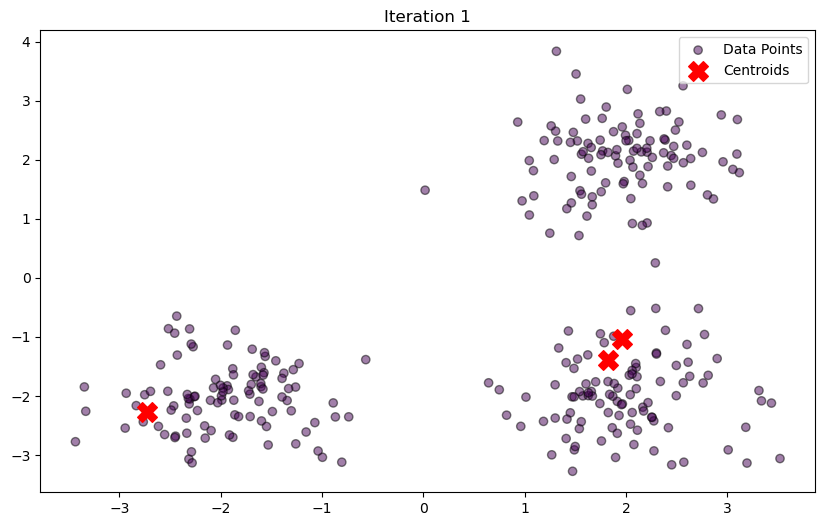

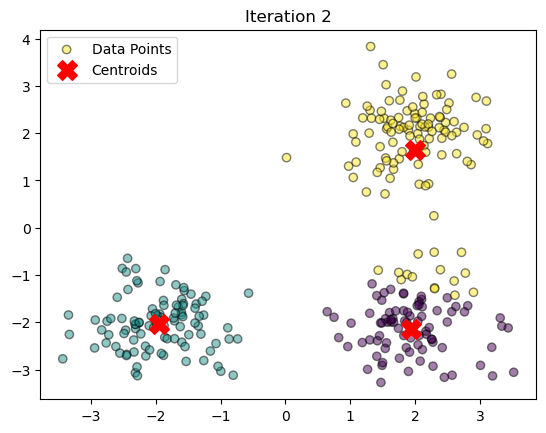

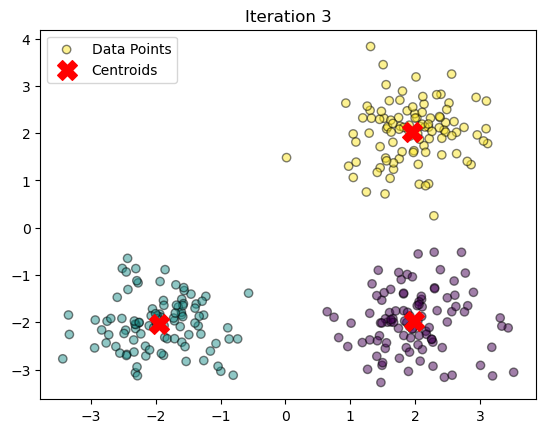

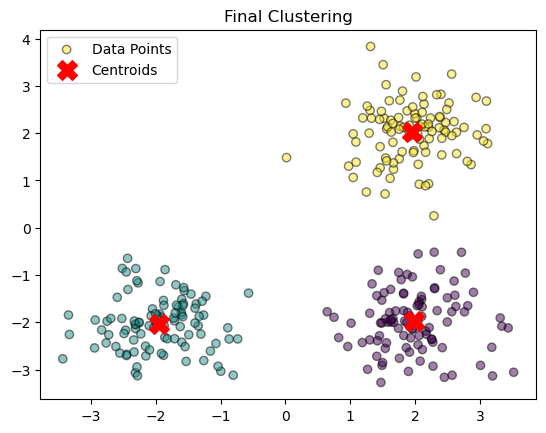

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate random blobs
def generate_blobs(n_samples, centers, cluster_std, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n_centers = len(centers)
    data = []
    labels = []
    for i, center in enumerate(centers):
        data.append(np.random.randn(n_samples // n_centers, 2) * cluster_std + center)
        labels.append(np.full(n_samples // n_centers, i))
    return np.vstack(data), np.hstack(labels)

# Generate data
centers = [(2, 2), (-2, -2), (2, -2)]
data, _ = generate_blobs(n_samples=300, centers=centers, cluster_std=0.60, random_state=0)

k = 3
n = data.shape[0]
d = data.shape[1]

# Initialize centroids
centroids = data[np.random.choice(n, k, replace=False)]

plt.figure(figsize=(10, 6))

max_iters = 10

clusters = np.zeros(n)

for it in range(max_iters):
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', alpha=0.5, label='Data Points')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title(f"Iteration {it + 1}")
    plt.legend()
    plt.pause(1)
    plt.clf()
    for i in range(n):
        distances = np.linalg.norm(data[i] - centroids, axis=1)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    new_centroids = np.array([data[clusters == i].mean(axis=0) for i in range(k)])

    if np.allclose(centroids, new_centroids):
        break

    centroids = new_centroids

plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', alpha=0.5, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title("Final Clustering")
plt.legend()
plt.show()


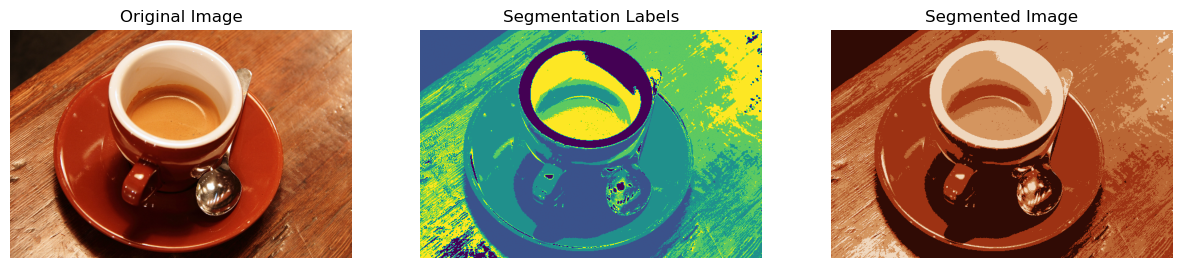

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

# Load a sample image
img = data.coffee()

# Convert image to (num_samples, num_features) format for clustering
data = img.reshape((-1, 3))
k = 5  # Number of clusters
n = data.shape[0]

# Randomly initialize the centroids
centroids = data[np.random.choice(n, k, replace=False)]

# Run the K-means algorithm
max_iters = 10
clusters = np.zeros(n)

for _ in range(max_iters):
    # Assign each point to the nearest centroid
    for i in range(n):
        distances = np.linalg.norm(data[i] - centroids, axis=1)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    
    # Recalculate centroids
    new_centroids = np.array([data[clusters == i].mean(axis=0) for i in range(k)])
    
    # Check for convergence
    if np.allclose(centroids, new_centroids, rtol=1e-4, atol=1e-4):
        break
    
    centroids = new_centroids

# Create a color image to visualize the segmentation
segmented_image = clusters.reshape(img.shape[0], img.shape[1])
segm_img = centroids[segmented_image.astype(int)]

# Display the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(segmented_image, cmap='viridis')
ax[1].set_title('Segmentation Labels')
ax[1].axis('off')

ax[2].imshow(segm_img.astype(np.uint8))
ax[2].set_title('Segmented Image')
ax[2].axis('off')

plt.show()

## Mean Shift
* **Density Estimation**: Consider feature space as the empirical p.d.f. of the represented parameters. Dense region corresponding to local maxima on p.d.f. Once such maxima if found, the cluster is delineated based on local structure.
* Mean shift operates on **feature space**, attempting to find areas of high data point density through a gradient ascent approach.
* It can operate directly in multi-dimensional feature space, and naturally identifies area of high pixel density. It is also capable of handling gradient.
<img src="images/fig1_MSGradient.png" width="55%">


## Mean Shift procedure
* For each data point $x_i$ in feature space, a window is define around it.
* The mean of data point $\mu_i$is calculated within the window.
* The data point $x_i$ is shift toward this mean value $\mu_i$.
* Repeat until a convergence point $z_i$ is reached.

After all data converage, data converage to same or nearby local maxima are consider to be part of same cluster.Multiple data points are thereby grouped into clusters based on their attraction to similar local maxima.

## Mean Shift Math
* Kernel desity estimator: estimate density at data point $x$
$$\hat{f}(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n K_H(\mathbf{x} - \mathbf{x}_i)
$$
* Kernel function: H is the bandwidth parameter
$$K_H(\mathbf{x}) = |\mathbf{H}|^{-1/2} K\left(\mathbf{H}^{-1/2} \mathbf{x}\right)
$$

## Mean Shift Math
* Mean shift use a special class of radially symmetrix kernels:
$$K(x)=c_{k,d} k(\|x\|^2)$$
    * $k(x)$ is profile of kernel
    * $c_{k,d}$ makes $K(x)$ ubtegrate to one.
* Let $\mathbf{H}$ be proportional to the identity matrix so we only have one bandwidth parameter
$$\mathbf{H} = h^2 \mathbf{I}$$
* We get:
$$\hat{f}_{h,K}(x) = \frac{c_{k,d}}{nhd} \sum_{i=1}^n k\left(\left\|\frac{x - x_i}{h}\right\|^2\right)$$
    * $n$ is number of data points
    * $h$ is assigned bandwidth
    * $d$ is dimension of feature space


## Mean Shift Math

Since we are looking for the mode of the density function, we need to have a density gradient estimator.

This formula is the gradient of the kernel density estimate with respect to x. The gradient points in the direction of the greatest rate of increase of the density estimate.
$$\nabla \hat{f}_{h,K}(\mathbf{x}) = \frac{2c_{k,d}}{nh^{d+2}} \sum_{i=1}^n (\mathbf{x} - \mathbf{x}_i)k'\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)
$$

* let $g(x) = -k'(x)$ and $G(x) = c_{g,d} g(\|x\|^2)$
* $\sum_{i=1}^ng\left(\left\|\frac{x-x_i}{h}\right\|^2\right)$ is assumed to be positive number.
$$\nabla \hat{f}_{h,K}(\mathbf{x}) = \frac{2c_{k,d}}{nh^{d+2}} \sum_{i=1}^n (\mathbf{x}_i - \mathbf{x}) g\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)$$
$$\nabla \hat{f}_{h,K}(\mathbf{x}) = \frac{2c_{k,d}}{nh^{d+2}}\left[\sum_{i=1}^n g\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)\right] \left[\frac{\sum_{i=1}^n \mathbf{x}_i g\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)} {\sum_{i=1}^n g\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)} - \mathbf{x}\right]
$$


## Mean Shift Math
* Now, $\hat{f}_{h,G}(\mathbf{x}) = \frac{c_{g,d}}{nh^d} \sum_{i=1}^n g\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)$ and let $\mathbf{m}_{h,G}(\mathbf{x}) = \frac{\sum_{i=1}^n \mathbf{x}_i g\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)}{\sum_{i=1}^n g\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)} - \mathbf{x}$
* The gradient $\nabla \hat{f}_{h,K}(\mathbf{x})=\frac{2c_{k,d}}{h^2c_{g,d}}\hat{f}_{h,G}(\mathbf{x})\mathbf{m}_{h,G}(\mathbf{x})$
* In result:
$$\mathbf{m}_{h,G}(\mathbf{x}) = \frac{1}{2}h^2c\frac{\nabla \hat{f}_{h,K}(\mathbf{x})}{\hat{f}_{h,G}(\mathbf{x})}$$
*  $\nabla \hat{f}_{h,K}(\mathbf{x})$ points at direction with maximum increase. $\hat{f}_{h,G}(\mathbf{x})$ is normalization term, ensuring the step size is not too large.
* The mean shift vector thus **always points towards the driection of maximum increase in density**.

## Mean Shift procedure
$$\mathbf{m}_{h,G}(\mathbf{x}) = \frac{\sum_{i=1}^n \mathbf{x}_i g\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)}{\sum_{i=1}^n g\left(\left\|\frac{\mathbf{x} - \mathbf{x}_i}{h}\right\|^2\right)} - \mathbf{x}$$

* With a dataset of $[x_1,x_2 ... x_n]$ Mean shift first apply kde to esitimate denisty
* For each data point, $x ← x + \mathbf{m}_{h,G}(x)$
* $\mathbf{m}_{h,G}(x)$ measure the mean surroundings $x$, using the weighted function $g$. It returns a step that moves the current data point towards the direction of maximum increase.
* After many iterations, data points within a threshold will be labeled as belonging to the same cluster.

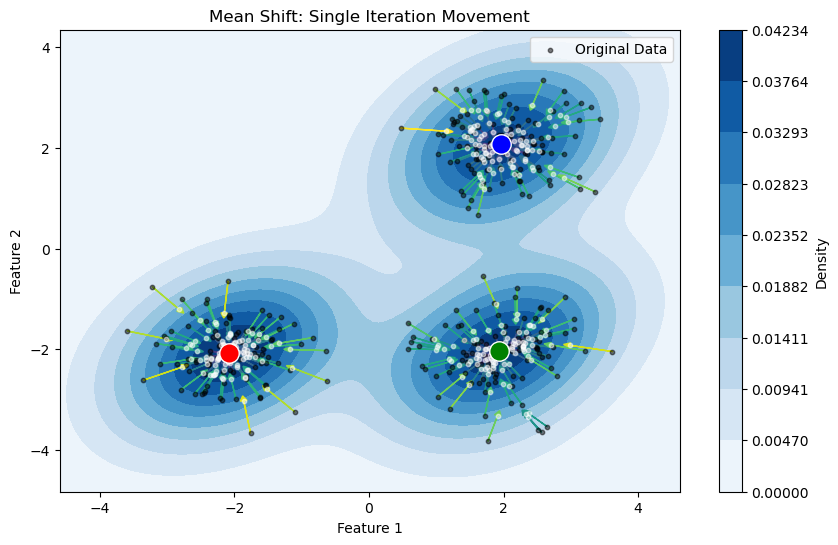

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
from matplotlib.cm import viridis

def generate_blobs(n_samples, centers, cluster_std, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n_centers = len(centers)
    data = []
    labels = []
    for i, center in enumerate(centers):
        data.append(np.random.randn(n_samples // n_centers, 2) * cluster_std + center)
        labels.append(np.full(n_samples // n_centers, i))
    return np.vstack(data), np.hstack(labels)

# Generate sample data
np.random.seed(0)
centers = [(2, 2), (-2, -2), (2, -2)]
data, _ = generate_blobs(n_samples=300, centers=centers, cluster_std=0.60, random_state=0)

# Mean Shift step
def mean_shift_step(data, bandwidth):
    new_positions = np.zeros_like(data)
    for i, point in enumerate(data):
        distances = cdist(data, np.array([point]))
        weights = np.exp(-distances ** 2 / (2 * bandwidth ** 2))
        weighted_sum = np.sum(data * weights, axis=0)
        new_position = weighted_sum / np.sum(weights)
        new_positions[i] = new_position

    return new_positions

def find_cluster_centers(data, bandwidth, max_iter=100, tol=1e-3):
    positions = data.copy()
    for _ in range(max_iter):
        new_positions = mean_shift_step(positions, bandwidth)
        if np.linalg.norm(new_positions - positions) < tol:
            break
        positions = new_positions
    unique_positions = np.unique(np.round(new_positions, 2), axis=0)
    return unique_positions

bw = 0.5
new_data = mean_shift_step(data, bw)
cluster_centers = find_cluster_centers(data, bw)
labels = np.zeros(data.shape[0])

for i, center in enumerate(cluster_centers):
    labels[np.all(np.isclose(new_data, center, atol=0.1), axis=1)] = i

kde = gaussian_kde(data.T, bw_method=0.5)

# Create a grid to evaluate KDE and calculate the gradient
xgrid = np.linspace(data[:, 0].min() - 1, data[:, 0].max() + 1, 100)
ygrid = np.linspace(data[:, 1].min() - 1, data[:, 1].max() + 1, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)
Gx, Gy = np.gradient(Z, xgrid[1] - xgrid[0], ygrid[1] - ygrid[0])
indices_x = np.clip(np.searchsorted(xgrid, data[:, 0]), 0, Gx.shape[1] - 1)
indices_y = np.clip(np.searchsorted(ygrid, data[:, 1]), 0, Gy.shape[0] - 1)
data_gradients_x = Gx[indices_y, indices_x]
data_gradients_y = Gy[indices_y, indices_x]

distances = np.linalg.norm(new_data - data, axis=1)
norm = Normalize(vmin=distances.min(), vmax=distances.max())
scalar_map = viridis(norm(distances))

plt.figure(figsize=(10, 6))
norms = Normalize(vmin=Z.min(), vmax=Z.max())
plt.contourf(Xgrid, Ygrid, Z, levels=np.linspace(Z.min(), Z.max(), 10), norm=norms, cmap='Blues')
plt.colorbar(label='Density')

# Dynamically assign colors based on the number of clusters
num_clusters = len(cluster_centers)
colors = ['red', 'green', 'blue']

for i, (col, center) in enumerate(zip(colors, cluster_centers)):
    members = labels == i
    plt.plot(center[0], center[1], 'o', markerfacecolor=col, markeredgecolor='white', markersize=14, alpha=1)

# Draw arrows indicating movement
for i in range(len(data)):
    plt.arrow(data[i, 0], data[i, 1],
              new_data[i, 0] - data[i, 0],
              new_data[i, 1] - data[i, 1],
              head_width=0.1, head_length=0.1, color=scalar_map[i])
    
plt.scatter(data[:, 0], data[:, 1], color='black', s=10, alpha=0.5, marker='o', label='Original Data')
plt.scatter(new_data[:, 0], new_data[:, 1], color='white', s=10, alpha=0.5, marker='o')

plt.title("Mean Shift: Single Iteration Movement")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## Mean Shift On Images
* Ability to handle gradient
* Depends on iteration
<img src="images/fig2_MeanShiftCoffee.png" width="90%">


## Mean Shift for Self Supervised Learning (2021)
* Motivation:
  * Most visual recognition algorithms are supervised and require expensive annotation processes.
  * Self-supervised learning (SSL) aim to learn representation from unlabeled images.
* Main Method
  * Contrast Measurement: pull different augmentations of an image instance together while pushing them away from other image instances.
  * Clustering Method: Cluster the unlabeled image to a set of clusters, and hope each cluster contain semantically similar images.

## Mean Shift Method
* Memory bank: Storage of all embedding vector from $f$
* Target encoder $f$: Updated by running average of $g$
  * found the k-nearest neighbour in the memory bank.
* Online encoder $g$ and Predictor $h$: Update by back-propagating the loss.
  * predicting an embedding.
* $f$ generate embedding based on surrounding neighbor's.
* $g$ uses $f$ generated embedding as the label to update itself.

<img src="images/fig3_MSFDiagram.png" width="90%">


## Mean Shift Method
* Augemented image $T_1$ and $T_2$ encoded by $f$ and $g$:
$$u=\frac{f(T_2(x))}{\|f(T_2(x))\|_2} \quad v=\frac{h(g(T_2(x)))}{\|h(g(T_2(x)))\|_2}$$
* $u = \{z_j\}_{j=1}^k$, are k set of embeddings found by nearest neighbor.
* Loss is the distance metric between two embeddings
$$L = \frac{1}{k} \sum_{j=1}^k dist(v,z_j)$$
<img src="images/fig4_NNtrainingByEpoch.png" width="100%">

## Performance
* Similar Performance with smaller scale (Batch Size and epochs)
<img src="images/fig5_ImageNetEvaluation.png" width="85%">


## Conclusion
MSF method uses mean shift ideal in the 'memory bank' that groups similar image embedding (semantic meaning) together by moving the current embedding toward the neighbour mean value.
* It provides similar performance as state-of-the-art contrasting models with a smaller scale.
* Lack of dependence on negative sampling or contrasting objects makes it flexible.
* It can be generalized in small datasets, which is useful in real life scenario where data is limited.
<img src="images/fig6_SmallImageNetEva.png" width="65%">


# Image Segmentation: Graph-based methods
Abby Bertics

## Recap

We've seen segmenting by putting similar things together:
* thresholding
* edge-based
* merging (region-growing)
* clustering (mean-shift)

Now:
* segmentation by breaking things apart

## Images as Graphs

### Motivation
* understanding structure and relationships
* makes some problems easier
* can use efficient graph algorithms!

### Definition

An image is graph, $G=(V,E)$ where
* each node $v_i \in V$ is a pixel in the image and
* the (undirected) edges $e_{ij} \in E$ connect pairs of pixels
* the weights $w(e_{ij})$ often represent how similar the two pixels are (eg, by intensity or colour)

#### Which edges?

* neighbors -- fast
* all pixels -- most information but excessive
* best: somewhere in between

### Which weights?

Define weight of edges by difference of brightness (or intensity, colour, texture, etc) values of pixels:

$$ w_{xy} = exp(\frac{-||F(x)-F(y)||^2}{\sigma_I^2}) $$


Equation from: [Shi and Malik 2000, IEEE](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=868688)


### Non-pixel, non-neighbour example

![image as graph complex](images/image-graph.png)

Source: [Han et al 2022 (NeurIPS)](https://arxiv.org/pdf/2206.00272)

## Segmentation as graph cut

### Intuition: 
* Grouping = Graph partitioning
* Contour = Graph cut
* Segment = Subgraph

![graph cut toy example](images/graph-cut.png "Graph Cut Toy Example")

source: https://www.baeldung.com/cs/graph-based-segmentation

### Math formulation

A graph $G=(V,E)$ can be split into two disjoint sets, $A$ and $B$ (such that $A\cup B = V$ and $A\cap B = \emptyset$) by removing the edges
connecting the two sets.

Dissimilarity between these two sets is total weight on the edges that have been removed.

$$cut(A,B)=\sum_{u\in A, v\in B}w(u,v)$$

## How to implement?

One option: chop graph at the weakest/least similar edges (ie, max-flow/min-cut)

But: this will often result in single pixel subsets.

<div>
<img src="images/bad-min-cut.png" width="600px"/>
</div>

* minimise cut value
* How?
*There are many (exponential) possible cuts. But luckily finding the min cut of a graph is a problem theorists have thought a lot about, and there are efficient algorithms to solve it.
* An Optimal Graph Theoretic Approach to Data Clustering: Theory and Its Application to Image Segmentation
(Wu and Leahy 1993, [IEEE](https://ieeexplore.ieee.org/document/244673))


## Norm graph cut

Normalized Cuts and Image Segmentation ([Shi and Malik 2000, IEEE](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=868688))

**Instead:**
* look for collections of edges that are weak relative to all of the edges both inside and emanating from a particular region
* new **global** criterion, "normalised cut"
    * measures similarity within groups **and** dissimilaraity among different groups

### Math definition

Disassociation measure:
$$Ncut(A,B) = \frac{cut(A,B)}{assoc(A,V)} + \frac{cut(A,B)}{assoc(B,V)}$$

Association measure:
$$Nassoc(A,B) = \frac{assoc(A,A)}{assoc(A,V)} + \frac{assoc(B,B)}{assoc(B,V)}$$

where $assoc(A,V)=\sum_{u\in A, t\in V}w(u,t)$ is the total connection from nodes in A to all nodes in the graph

### Nifty insight

Because $cut(A,B)=assoc(A,V)-assoc(A,A)$, we get:
$$Ncut(A,B) = 2 - Nassoc(A,B)$$


**minimising disassociation and maximising association are *THE SAME THING!***



### Physical analogy

* spring-mass system where springs are pixels and each graph-edge weight is the stiffness of spring
* shake the system hard to make the springs oscillate 
* those w similar connections will shake together
* and then as it gets more violent, the weak springs attached will pop off
* fundamental modes of oscilation are the eigenvectors!

### Implementation

Minor snafu:
* computing the optimal normalized cut is **NP-complete**

Solution (tl;dr version):
* Rewrite problem so that it is a linear-algebra one that we can solve quickly using eigenvalues.



#### Solution explained
Rewrite problem so that it is a linear-algebra one that we can solve quickly using eigenvalues.


If you define things smartly...
* $\textbf{W}$ is $NxN$ symmetrical matrix with $W(i,j)=w_{ij}$.
* $\textbf{D}$ is $NxN$ diagonal matrix with $d(i)=\sum_jw(i,j)$ on diagonal.
* $y = (\textbf{1}+x) - b(\textbf{1}-x)$ where
    * $\textbf{1}$ is a $Nx1$ vector of ones.
    * $x$ is an $Nx1$ indicator vector, $x_i=1$ if node $i$ is in $A$ and -1 otherwise.
    * $b = \frac{\sum_{x_i>0}d_i}{\sum_{x_i<0}d_i}$ (this is highest when groups are evenly split!)
    
It will give us:
$$min_xNcut(x) = min_y\frac{y^T(\textbf{D}-\textbf{W})y}{y^T\textbf{D}y}$$
with the condition $y(i)\in\{1,-b\}$ and $y^T\textbf{D1}=0$.


##### Some very unnecessary math
$$min_xNcut(x) = min_y\frac{y^T(\textbf{D}-\textbf{W})y}{y^T\textbf{D}y}$$

This expression is the Rayleigh quotient. If you relax $y$ to take on real values, then you can minimise it by solving the generalised eigenvalue system
$$(\textbf{D}-\textbf{W})y = \lambda\textbf{D}y.$$

You can rewrite that as
$$\textbf{D}^\frac{-1}{2}(\textbf{D}-\textbf{W})\textbf{D}^\frac{-1}{2}z = \lambda z$$
where $z=\textbf{D}^\frac{1}{2}y$.

Then "one can easily verify that":
* $z_0=\textbf{D}^\frac{1}{2}\textbf{1}$ is an eigenvector of that with an eigenvalue of 0.
* $z_0$ is the smallest eigenvector and all eigenvectors are perpendicular to each other.
* The second smallest eigenvector, $z_1$ can be defined $0=z_1^Tz_0$

So, translated back to the original system:
* $y_0=\textbf{1}$ is the smallest eigenvector with eigenvalue of 0.
* the second smallest, $y_1$ is defined $0=y_1^T\textbf{D1}$


Bc of a nice fact about the Rayleigh quotient, we know that if the eigenvectors are orthogonal, the quotient is minimised by finding the next smallest eigenvector, and its minimum value corresponds to that eigenvalue.

So:

$z_1 = arg.min_{z^Tz_0=0}\frac{z^T\textbf{D}^\frac{-1}{2}(\textbf{D}-\textbf{W})\textbf{D}^\frac{-1}{2}z}{z^Tz}$$
$

$y_1 = arg.min_{y_1^T\textbf{D1}=0}\frac{y(\textbf{D}-\textbf{W})y}{y^T\textbf{D}y}$$
$

Which makes the 2nd smallest eigenvector the real-valued solution to our normalised cut problem.

Fun fact: 
* the third smallest eigenvalue is the real-valued solution that optimally subpartitions the first two parts, and the fourth optimally subdivides the existing graphs, and so on.
* but, in practice, because of the error switching from real to discrete, solutions based on higher ordered eigenvalues become unreliable. So best to recurse and solve iteratively.

* There have been various speed-ups of this algorithm since then, eg,  Pont-Tuset, Arbela ́ez et al. (2017)

## Norm cut algorithm

1. Given a set of features, set up a weighted graph
$G = (V,E)$, compute the weight on each edge, and
summarize the information into W and D.
    * D is NxN diagonal matrix
    * W is NxN symmetric matrix
2. Solve $(\textbf{D}-\textbf{W})x = \lambda\textbf{D}x.$ for eigenvectors with the smallest eigenvalues.
3. Use the eigenvector with the second smallest eigenvalue to bipartition the graph by finding the splitting point such that Ncut is minimized.
4. Decide if the current partition should be subdivided by checking the stability of the cut, and make sure Ncut is below the prespecified value.
5. Recurse.

## Norm cut code

### Making plotting nicer

In [1]:
# might have to do this on colab if old version is installed to fix errors with graph.rag_mean_color
# ! pip install -U scikit-image

from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (4, 3)

def format_image(title):
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Step 1: Load image

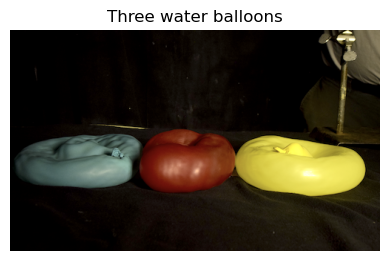

In [2]:
# this is code for norm-cut graph segmentation
# source: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_ncut.html#sphx-glr-download-auto-examples-segmentation-plot-ncut-py

from skimage import data, graph, io, segmentation, color

### Step 1: Load image ###
img = io.imread("images/balloons.png")[:,:,:3] # remove alpha channel
# img = data.coffee() # or just use the provided one
plt.imshow(img)
format_image("Three water balloons")

### Step 2: Convert image into graph

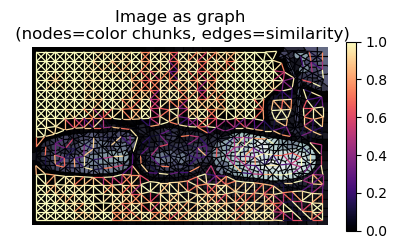

In [3]:
### Step 2: Convert image into graph ###

# Segment image using k-means clustering in Color-(x,y,z) space.
labels1 = segmentation.slic(img, compactness=30, n_segments=600, start_label=1)
# Return an RGB image where color-coded labels are painted over the image.
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)
# Compute the Region Adjacency Graph using mean colors.
g = graph.rag_mean_color(img, labels1, mode='similarity')


# Plot RAG; can adjust k to show more or less detail
plt.colorbar(graph.show_rag(labels1, g, out1, edge_width=.9), shrink=0.7, alpha=.2)
format_image("Image as graph\n (nodes=color chunks, edges=similarity)")

### Step 3: Perform normalised graph cut

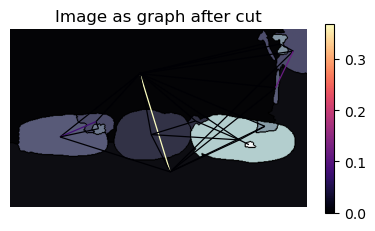

In [4]:
### Step 3: Recursively perform Normalized Graph cut on the Region Adjacency Graph. ###
labels2 = graph.cut_normalized(labels1, g)
# Return an RGB image where color-coded labels are painted over the image.
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

# Make graph from norm-cut labels
g2 = graph.rag_mean_color(img, labels2, mode='similarity')

plt.colorbar(graph.show_rag(labels2, g2, out2, edge_width=.9), shrink=0.7, alpha=.2)
format_image("Image as graph after cut")

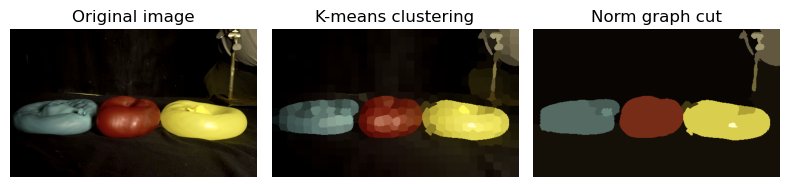

In [9]:
# Make plot.
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(8, 10))

ax[0].imshow(img)
ax[1].imshow(out1)
ax[2].imshow(out2)

ax[0].set_title("Original image")
ax[1].set_title("K-means clustering")
ax[2].set_title("Norm graph cut")

for a in ax:
    a.axis('off')
plt.tight_layout()

### Other graph based methods:
* Random Walks for Image Segmentation ([Grady 2006](https://ieeexplore.ieee.org/abstract/document/1704833))
* minimum spanning trees
* watershed segmentation



## Fancy new paper


TokenCut Segmenting Objects in Images and Videos With Self-Supervised Transformer and Normalized Cut

Wang et al 2023 ([IEEE Transactions on Pattern Analysis and Machine Intelligence](https://ieeexplore.ieee.org/abstract/document/10224285); [arxiv](https://arxiv.org/abs/2209.00383))



Problem:
* current approaches to object detection and segmentation rely on supervised learning (ie, large, high-quality, annotated data)

Insight:
* self-supervised transformers learn attention maps that contain meaningful information
* but maps are noisy and cannot be used directly

<img src="images/parrot.png" width="500px">

Their approach:
* self-supervised transformers + graph-based algorithm

### "TokenCut" Method

1. **Create fully-connected graph** where 
    * nodes are patches with feature vectors learned by the transformer
    * edge weights are pairwise cosine-similarity scores between nodes
    * (video uses average of appearance and optical-flow similarity scores)
2. Segment image using **normalised-cut** algorithm
3. **Refine edges** using Bilateral Solver or Conditional Random Field

<img src="images/fancy-fig2.png" >

### Video example
<img src="images/videoex.png">

### Benchmarking

Three tasks:
1. unsupervised single object discovery
2. unsupervised saliency detection
3. unsupervised video segmentation

They just have absolute accuracy values in their table, so it's not worth showing... But the numbers are similar to or above "state-of-the-art" models

## Alt applied new paper

A full-resolution convolutional network with a dynamic graph cut algorithm for skin cancer classification and detection

[Adla et al 2023 (Healthcare Analytics)](https://www.sciencedirect.com/science/article/pii/S2772442523000217)




#### Problem background

Skin cancer classification.

Dermatoscope images may enable skin cancer specialists to manually identify the malignant area, but doing so is still a taxing task for them. For this reason, automated approaches have been developed to streamline the procedure. In this research, a new CAD system with minimal hardware and software requirements is proposed for automated skin lesion classification.

Data:
* train set: 33,126 jpeg images, labelled cancer and non-melanoma
* test set: 10,982 images

<img src="images/skin-cancer.jpg">


#### Model

* full-resolution convolutional neural networks (CNNs) are popular for semantic segmentation
* but sensitive to hyperparameters, and those take time to manually fine-tune

So:
* optimise hyperparameters using a dynamic graph-cut algorithm

Dynamic graph cut algorithm

data preprocessing -> segmentation -> classification

<img src="images/cancer-gc.jpg">
